In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import schema_to_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetPath('star-wars')
schema = DatasetSchema.load_schema(DATASET.name)
G = schema_to_igraph(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


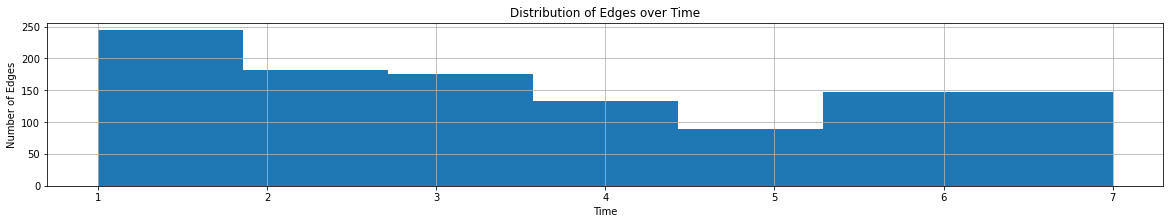

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 113
Number of Edges: 2078
Density: 0.3283817951959545


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 36.7787610619469
Median Degree: 18.0


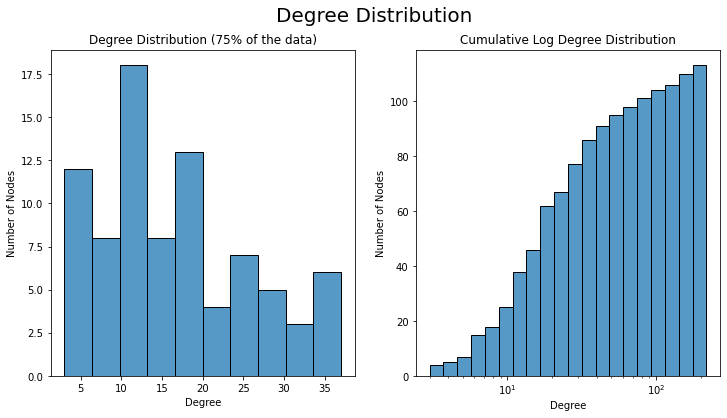

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,217,OBI-WAN
1,203,ANAKIN
2,194,C-3PO
3,159,PADME
4,156,EMPEROR
5,152,LUKE
6,142,LEIA
7,138,HAN
8,121,YODA
9,114,JAR JAR


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [15]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [16]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.747
Diameter: 5


In [17]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,113.000000,113.000000,113.000000,113.000000,109.000000
mean,0.328382,0.011824,0.073137,0.008850,0.777146
std,0.398823,0.053582,0.059429,0.007155,0.231245
min,0.026786,0.000000,0.000870,0.001795,0.263842
25%,0.107143,0.000000,0.024360,0.003927,0.626667
50%,0.160714,0.000000,0.065530,0.006555,0.833333
75%,0.348214,0.003278,0.096457,0.010475,1.000000
max,1.937500,0.396039,0.250634,0.033249,1.000000


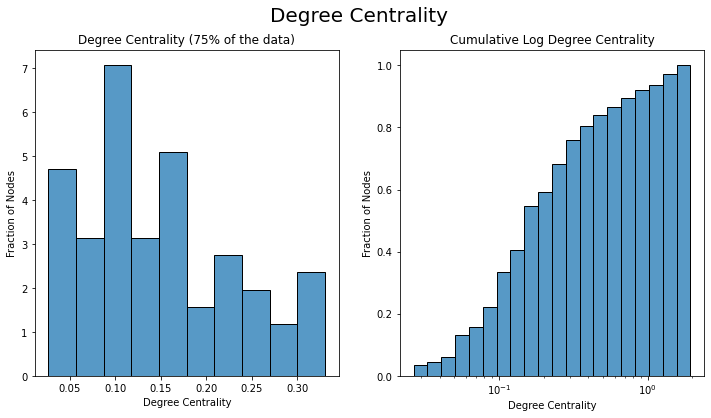

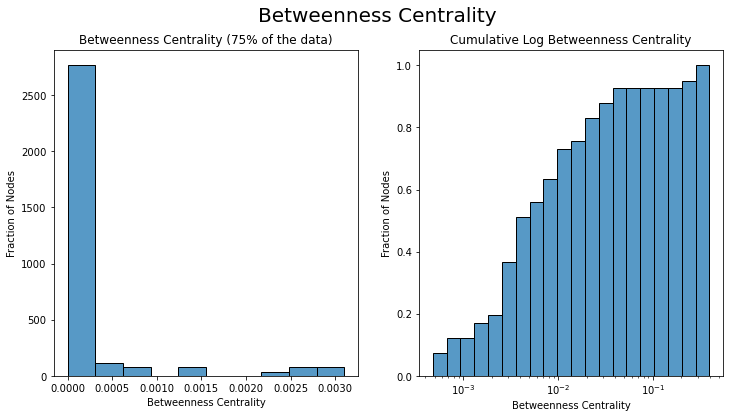

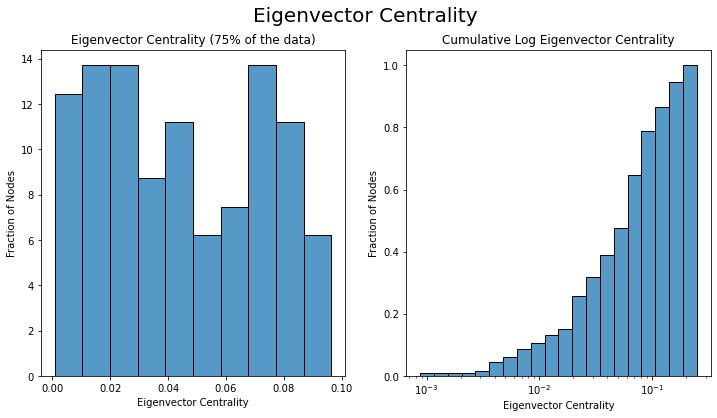

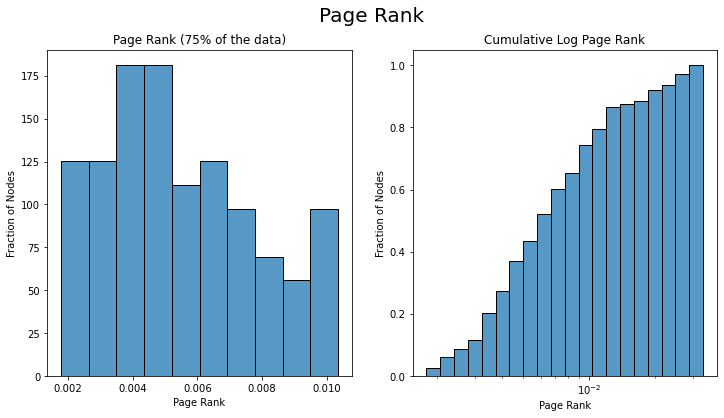

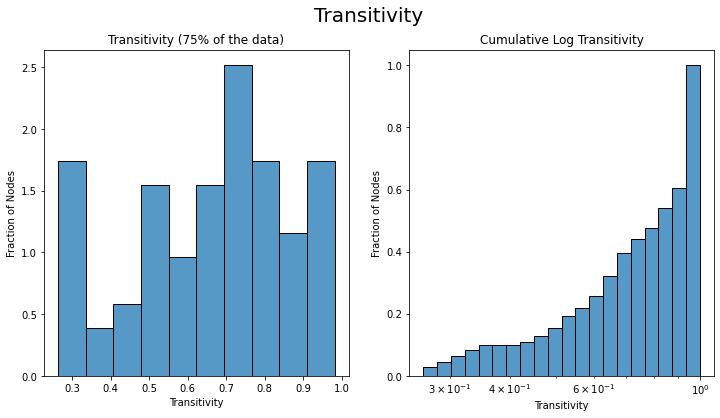

In [18]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [19]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.937500,OBI-WAN,0.396039,EMPEROR,0.250634,R2-D2,0.033249,OBI-WAN,1.0,GOLD FIVE
1,1.812500,ANAKIN,0.350450,LEIA,0.248277,OBI-WAN,0.032254,R2-D2,1.0,ODD BALL
2,1.732143,C-3PO,0.222200,DARTH VADER,0.238940,ANAKIN,0.031421,ANAKIN,1.0,BRAVO TWO
3,1.419643,PADME,0.042791,OBI-WAN,0.224263,C-3PO,0.028006,C-3PO,1.0,NEEDA
4,1.392857,EMPEROR,0.041965,ANAKIN,0.219640,PADME,0.027744,LUKE,1.0,BRAVO THREE
5,1.357143,LUKE,0.030603,PADME,0.215457,EMPEROR,0.027734,PADME,1.0,JIRA
6,1.267857,LEIA,0.029272,POE,0.188527,YODA,0.026941,EMPEROR,1.0,MAZ
7,1.232143,HAN,0.025481,LUKE,0.181848,LEIA,0.024732,LEIA,1.0,NIV LEK
8,1.080357,YODA,0.024842,R2-D2,0.181549,LUKE,0.023856,HAN,1.0,WALD
9,1.017857,JAR JAR,0.019676,HAN,0.169860,JAR JAR,0.021173,CHEWBACCA,1.0,ELLO ASTY


## Connected Components Statistics

In [20]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 1
Size of the largest component: 113


Text(0.5, 1.0, 'Connected Components')

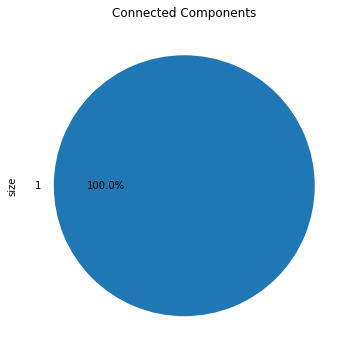

In [21]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [22]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Character,Character,113,36.778761,18.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

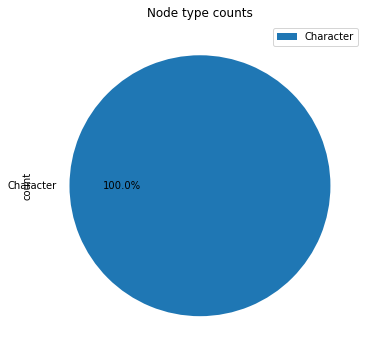

In [23]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

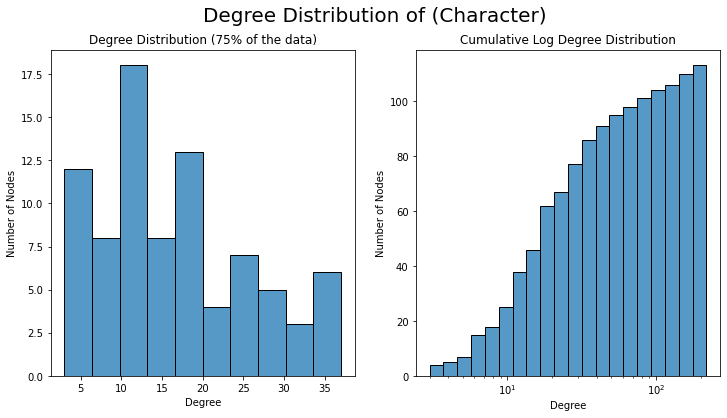

In [24]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [25]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Character)


,value,label
0,217,OBI-WAN
1,203,ANAKIN
2,194,C-3PO
3,159,PADME
4,156,EMPEROR
5,152,LUKE
6,142,LEIA
7,138,HAN
8,121,YODA
9,114,JAR JAR


### Edge Type Statistics

In [26]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 2


,type,count
INTERACTS_WITH,INTERACTS_WITH,958
MENTIONS,MENTIONS,1120


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

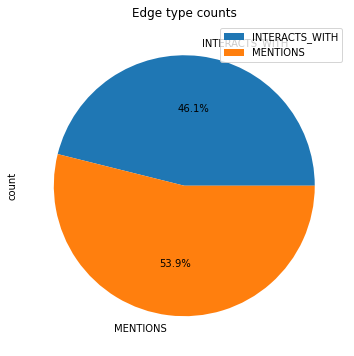

In [27]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [28]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [29]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Character


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.937500,OBI-WAN,0.396039,EMPEROR,0.250634,R2-D2,0.033249,OBI-WAN,1.0,ODD BALL
1,1.812500,ANAKIN,0.350450,LEIA,0.248277,OBI-WAN,0.032254,R2-D2,1.0,ORN FREE TAA
2,1.732143,C-3PO,0.222200,DARTH VADER,0.238940,ANAKIN,0.031421,ANAKIN,1.0,CLIEGG
3,1.419643,PADME,0.042791,OBI-WAN,0.224263,C-3PO,0.028006,C-3PO,1.0,JOBAL
4,1.392857,EMPEROR,0.041965,ANAKIN,0.219640,PADME,0.027744,LUKE,1.0,PLO KOON
5,1.357143,LUKE,0.030603,PADME,0.215457,EMPEROR,0.027734,PADME,1.0,CLONE COMMANDER CODY
6,1.267857,LEIA,0.029272,POE,0.188527,YODA,0.026941,EMPEROR,1.0,GIDDEAN DANU
7,1.232143,HAN,0.025481,LUKE,0.181848,LEIA,0.024732,LEIA,1.0,CLONE COMMANDER GREE
8,1.080357,YODA,0.024842,R2-D2,0.181549,LUKE,0.023856,HAN,1.0,CAMIE
9,1.017857,JAR JAR,0.019676,HAN,0.169860,JAR JAR,0.021173,CHEWBACCA,1.0,MOTTI


# Clustering

## No Clustering Modularity

In [30]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [31]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.3604757341450513
Number of communities: 4


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

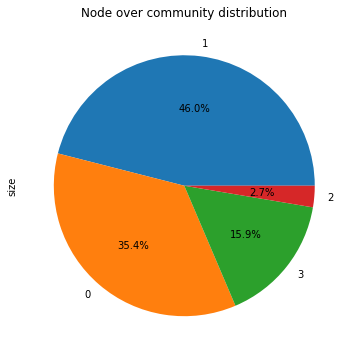

In [32]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [33]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.732143,C-3PO,0.350450,LEIA,0.250634,R2-D2,0.032254,R2-D2,1.0,RIEEKAN
1,1.357143,LUKE,0.222200,DARTH VADER,0.224263,C-3PO,0.028006,C-3PO,1.0,NEEDA
2,1.267857,LEIA,0.025481,LUKE,0.181848,LEIA,0.027744,LUKE,1.0,ZEV
3,1.232143,HAN,0.024842,R2-D2,0.181549,LUKE,0.024732,LEIA,1.0,YOUNG GIRL
4,0.982143,R2-D2,0.019676,HAN,0.162855,DARTH VADER,0.023856,HAN,1.0,RED TEN
5,0.910714,DARTH VADER,0.012970,TARKIN,0.160818,HAN,0.021173,CHEWBACCA,1.0,CLIEGG
6,0.544643,CHEWBACCA,0.010174,CHEWBACCA,0.152611,CHEWBACCA,0.020597,DARTH VADER,1.0,DERLIN
7,0.491071,LANDO,0.009089,WEDGE,0.132434,BOBA FETT,0.013812,SNAP,1.0,ADMIRAL STATURA
8,0.491071,JABBA,0.005181,C-3PO,0.125780,JABBA,0.013463,BOBA FETT,1.0,BOUSHH
9,0.437500,BOBA FETT,0.004284,JABBA,0.123199,SNAP,0.012117,JABBA,1.0,MOTTI


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.937500,OBI-WAN,0.396039,EMPEROR,0.248277,OBI-WAN,0.033249,OBI-WAN,1.0,TION MEDON
1,1.812500,ANAKIN,0.042791,OBI-WAN,0.238940,ANAKIN,0.031421,ANAKIN,1.0,CLONE COMMANDER CODY
2,1.419643,PADME,0.041965,ANAKIN,0.219640,PADME,0.027734,PADME,1.0,SUN RIT
3,1.392857,EMPEROR,0.030603,PADME,0.215457,EMPEROR,0.026941,EMPEROR,1.0,BRAVO TWO
4,1.080357,YODA,0.016462,NUTE GUNRAY,0.188527,YODA,0.019809,JAR JAR,1.0,VALORUM
5,1.017857,JAR JAR,0.012536,JAR JAR,0.169860,JAR JAR,0.019253,YODA,1.0,BRAVO THREE
6,0.812500,QUI-GON,0.005492,QUI-GON,0.154886,QUI-GON,0.017256,QUI-GON,1.0,WALD
7,0.776786,MACE WINDU,0.003607,COUNT DOOKU,0.143424,BAIL ORGANA,0.014014,BAIL ORGANA,1.0,ODD BALL
8,0.669643,BAIL ORGANA,0.003606,YODA,0.140834,MACE WINDU,0.013575,COUNT DOOKU,1.0,CLONE COMMANDER GREE
9,0.607143,NUTE GUNRAY,0.003278,WATTO,0.138407,COUNT DOOKU,0.013468,NUTE GUNRAY,1.0,GIDDEAN DANU


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.107143,RUWEE,0.0,RUWEE,0.019817,RUWEE,0.003927,RUWEE,1.0,RUWEE
1,0.107143,JOBAL,0.0,JOBAL,0.019817,JOBAL,0.003927,JOBAL,1.0,JOBAL
2,0.107143,SOLA,0.0,SOLA,0.019817,SOLA,0.003927,SOLA,1.0,SOLA


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.428571,POE,0.029272,POE,0.072165,POE,0.013330,POE,1.000000,LIEUTENANT MITAKA
1,0.392857,FINN,0.011720,KYLO REN,0.071945,REY,0.012923,FINN,1.000000,NIV LEK
2,0.312500,KYLO REN,0.009089,GENERAL HUX,0.067807,BB-8,0.010938,KYLO REN,1.000000,YOLO ZIFF
3,0.276786,REY,0.007595,FINN,0.066678,KYLO REN,0.010475,REY,1.000000,BALA-TIK
4,0.178571,CAPTAIN PHASMA,0.004173,REY,0.065530,FINN,0.009257,BB-8,1.000000,MAZ
5,0.160714,JESS,0.003305,SNOKE,0.045465,LOR SAN TEKKA,0.007336,GENERAL HUX,1.000000,ELLO ASTY
6,0.160714,GENERAL HUX,0.001387,BB-8,0.044008,MAZ,0.006819,JESS,0.972222,UNKAR PLUTT
7,0.151786,BB-8,0.000699,LOR SAN TEKKA,0.043346,UNKAR PLUTT,0.006199,SNOKE,0.861111,SNOKE
8,0.133929,LOR SAN TEKKA,0.000000,COLONEL DATOO,0.042390,SNOKE,0.006016,LOR SAN TEKKA,0.833333,LOR SAN TEKKA
9,0.125000,MAZ,0.000000,NIV LEK,0.026137,CAPTAIN PHASMA,0.005990,UNKAR PLUTT,0.750000,CAPTAIN PHASMA


No node timestamp data available


### Label Propagation

In [34]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.34484727485616296
Number of communities: 2


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

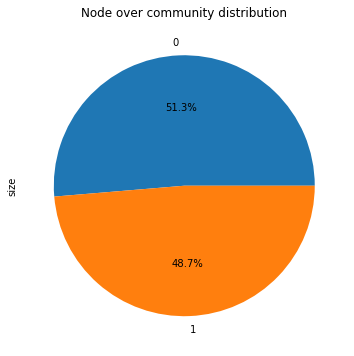

In [35]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [36]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.732143,C-3PO,0.350450,LEIA,0.250634,R2-D2,0.032254,R2-D2,1.0,LIEUTENANT MITAKA
1,1.357143,LUKE,0.222200,DARTH VADER,0.224263,C-3PO,0.028006,C-3PO,1.0,RED TEN
2,1.267857,LEIA,0.029272,POE,0.181848,LEIA,0.027744,LUKE,1.0,NIV LEK
3,1.232143,HAN,0.025481,LUKE,0.181549,LUKE,0.024732,LEIA,1.0,JERJERROD
4,0.982143,R2-D2,0.024842,R2-D2,0.162855,DARTH VADER,0.023856,HAN,1.0,BALA-TIK
5,0.910714,DARTH VADER,0.019676,HAN,0.160818,HAN,0.021173,CHEWBACCA,1.0,OZZEL
6,0.544643,CHEWBACCA,0.012970,TARKIN,0.152611,CHEWBACCA,0.020597,DARTH VADER,1.0,GOLD FIVE
7,0.491071,JABBA,0.011720,KYLO REN,0.132434,BOBA FETT,0.013812,SNAP,1.0,NEEDA
8,0.491071,LANDO,0.010174,CHEWBACCA,0.125780,JABBA,0.013463,BOBA FETT,1.0,DERLIN
9,0.437500,BOBA FETT,0.009089,GENERAL HUX,0.123199,SNAP,0.013330,POE,1.0,MOTTI


No timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,1.937500,OBI-WAN,0.396039,EMPEROR,0.248277,OBI-WAN,0.033249,OBI-WAN,1.0,TION MEDON
1,1.812500,ANAKIN,0.042791,OBI-WAN,0.238940,ANAKIN,0.031421,ANAKIN,1.0,JIRA
2,1.419643,PADME,0.041965,ANAKIN,0.219640,PADME,0.027734,PADME,1.0,JOBAL
3,1.392857,EMPEROR,0.030603,PADME,0.215457,EMPEROR,0.026941,EMPEROR,1.0,RUWEE
4,1.080357,YODA,0.016462,NUTE GUNRAY,0.188527,YODA,0.019809,JAR JAR,1.0,ORN FREE TAA
5,1.017857,JAR JAR,0.012536,JAR JAR,0.169860,JAR JAR,0.019253,YODA,1.0,PLO KOON
6,0.812500,QUI-GON,0.005492,QUI-GON,0.154886,QUI-GON,0.017256,QUI-GON,1.0,BRAVO TWO
7,0.776786,MACE WINDU,0.003607,COUNT DOOKU,0.143424,BAIL ORGANA,0.014014,BAIL ORGANA,1.0,BRAVO THREE
8,0.669643,BAIL ORGANA,0.003606,YODA,0.140834,MACE WINDU,0.013575,COUNT DOOKU,1.0,CLONE COMMANDER CODY
9,0.607143,NUTE GUNRAY,0.003278,WATTO,0.138407,COUNT DOOKU,0.013468,NUTE GUNRAY,1.0,PK-4


No timestamp data available
